### Implementing CDFs

Copyright 2019 Allen Downey

BSD 3-clause license: https://opensource.org/licenses/BSD-3-Clause

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('white')

import matplotlib.pyplot as plt

In [2]:
import inspect

def psource(obj):
    """Prints the source code for a given object.

    obj: function or method object
    """
    print(inspect.getsource(obj))

### Constructor

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/11).

The `Cdf` class inherits from `pd.Series`.  The `__init__` method is essentially unchanged, but it includes a workaround for what I think is bad behavior.

In [3]:
from empyrical_dist import Cdf

psource(Cdf.__init__)

    def __init__(self, *args, **kwargs):
        """Initialize a Cdf.

        Note: this cleans up a weird Series behavior, which is
        that Series() and Series([]) yield different results.
        See: https://github.com/pandas-dev/pandas/issues/16737
        """
        if args:
            super().__init__(*args, **kwargs)
        else:
            underride(kwargs, dtype=np.float64)
            super().__init__([], **kwargs)



You can create an empty `Cdf` and then add elements.

Here's a `Cdf` that representat a four-sided die.

In [4]:
d4 = Cdf()

In [5]:
d4[1] = 1
d4[2] = 2
d4[3] = 3
d4[4] = 4

In [6]:
d4

,probs
1,1
2,2
3,3
4,4


In a normalized `Cdf`, the last probability is 1.

`normalize` makes that true.  The return value is the total probability before normalizing.

In [7]:
psource(Cdf.normalize)

    def normalize(self):
        """Make the probabilities add up to 1 (modifies self).

        :return: normalizing constant
        """
        total = self.ps[-1]
        self /= total
        return total



In [8]:
d4.normalize()

4

Now the Cdf is normalized.

In [9]:
d4

,probs
1,0.25
2,0.50
3,0.75
4,1.00


### Properties

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/2).

In a `Cdf` the index contains the quantities (`qs`) and the values contain the probabilities (`ps`).

These attributes are available as properties that return arrays (same semantics as the Pandas `values` property)

In [10]:
d4.qs

array([1, 2, 3, 4])

In [11]:
d4.ps

array([0.25, 0.5 , 0.75, 1.  ])

### Sharing

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/12).

Because `Cdf` is a `Series` you can initialize it with any type `Series.__init__` can handle.

Here's an example with a dictionary.

In [12]:
d = dict(a=1, b=2, c=3)
cdf = Cdf(d)
cdf.normalize()
cdf

,probs
a,0.333333
b,0.666667
c,1.000000


Here's an example with two lists.

In [13]:
qs = [1,2,3,4]
ps = [0.25, 0.5, 0.75, 1.0]
d4 = Cdf(ps, index=qs)
d4

,probs
1,0.25
2,0.50
3,0.75
4,1.00


You can copy a `Cdf` like this.

In [14]:
d4_copy = Cdf(d4)
d4_copy

,probs
1,0.25
2,0.50
3,0.75
4,1.00


However, you have to be careful about sharing.  In this example, the copies share the arrays:

In [15]:
d4.index is d4_copy.index

True

In [16]:
d4.ps is d4_copy.ps

True

You can avoid sharing with `copy=True`

In [17]:
d4_copy = Cdf(d4, copy=True)
d4_copy

,probs
1,0.25
2,0.50
3,0.75
4,1.00


In [18]:
d4.index is d4_copy.index

False

In [19]:
d4.ps is d4_copy.ps

False

Or by calling `copy` explicitly.

In [20]:
d4_copy = d4.copy()
d4_copy

,probs
1,0.25
2,0.50
3,0.75
4,1.00


In [21]:
d4.index is d4_copy.index

False

In [22]:
d4.ps is d4_copy.ps

False

### Displaying CDFs

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/13).

`Cdf` provides `_repr_html_`, so it looks good when displayed in a notebook.

In [23]:
psource(Cdf._repr_html_)

    def _repr_html_(self):
        """Returns an HTML representation of the series.

        Mostly used for Jupyter notebooks.
        """
        df = pd.DataFrame(dict(probs=self))
        return df._repr_html_()



`Cdf` provides `plot`, which plots the Cdf as a line.

In [24]:
psource(Cdf.plot)

    def plot(self, **options):
        """Plot the Cdf as a line.

        :param options: passed to plt.plot
        :return:
        """
        underride(options, label=self.name)
        plt.plot(self.qs, self.ps, **options)



In [25]:
def decorate_dice(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Outcome')
    plt.ylabel('CDF')
    plt.title(title)

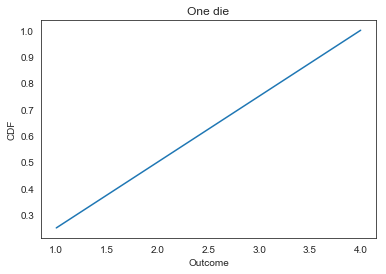

In [26]:
d4.plot()
decorate_dice('One die')

`Cdf` also provides `step`, which plots the Cdf as a step function.

In [27]:
psource(Cdf.step)

    def step(self, **options):
        """Plot the Cdf as a step function.

        :param options: passed to plt.step
        :return:
        """
        underride(options, label=self.name, where='post')
        plt.step(self.qs, self.ps, **options)



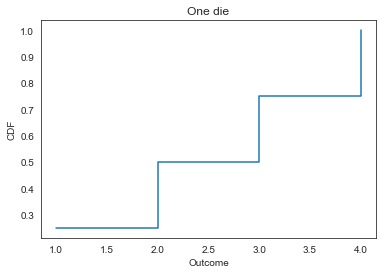

In [28]:
d4.step()
decorate_dice('One die')

### Make Cdf from sequence

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/14).


The following function makes a `Cdf` object from a sequence of values.

In [29]:
psource(Cdf.from_seq)

    @staticmethod
    def from_seq(seq, normalize=True, sort=True, **options):
        """Make a CDF from a sequence of values.

        seq: any kind of sequence
        normalize: whether to normalize the Cdf, default True
        sort: whether to sort the Cdf by values, default True
        options: passed to the pd.Series constructor

        :return: CDF object
        """
        pmf = Pmf.from_seq(seq, normalize=False, sort=sort, **options)
        return pmf.make_cdf(normalize=normalize)



In [30]:
cdf = Cdf.from_seq(list('allen'))
cdf

,probs
a,0.2
e,0.4
l,0.8
n,1.0


In [31]:
cdf = Cdf.from_seq(np.array([1, 2, 2, 3, 5]))
cdf

,probs
1,0.2
2,0.6
3,0.8
5,1.0


### Selection

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/15).

`Cdf` inherits [] from Series, so you can look up a quantile and get its cumulative probability.

In [32]:
d4[1]

0.25

In [33]:
d4[4]

1.0

`Cdf` objects are mutable, but in general the result is not a valid Cdf.

In [34]:
d4[5] = 1.25
d4

,probs
1,0.25
2,0.50
3,0.75
4,1.00
5,1.25


In [35]:
d4.normalize()
d4

,probs
1,0.2
2,0.4
3,0.6
4,0.8
5,1.0


### Evaluating CDFs

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/16).

Evaluating a `Cdf` forward maps from a quantity to its cumulative probability.

In [36]:
d6 = Cdf.from_seq([1,2,3,4,5,6])

In [37]:
d6.forward(3)

array(0.5)

`forward` interpolates, so it works for quantities that are not in the distribution.

In [38]:
d6.forward(3.5)

array(0.5)

In [39]:
d6.forward(0)

array(0.)

In [40]:
d6.forward(7)

array(1.)

`__call__` is a synonym for `forward`, so you can call the `Cdf` like a function (which it is).

In [41]:
d6(1.5)

array(0.16666667)

`forward` can take an array of quantities, too.

In [42]:
def decorate_cdf(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Quantity')
    plt.ylabel('CDF')
    plt.title(title)

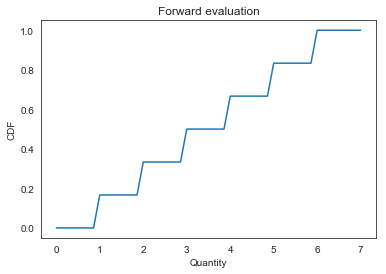

In [43]:
qs = np.linspace(0, 7)
ps = d6(qs)
plt.plot(qs, ps)
decorate_cdf('Forward evaluation')

`Cdf` also provides `inverse`, which computes the inverse `Cdf`:

In [44]:
d6.inverse(0.5)

array(3.)

`quantile` is a synonym for `inverse`

In [45]:
d6.quantile(0.5)

array(3.)

`inverse` and `quantile` work with arrays 

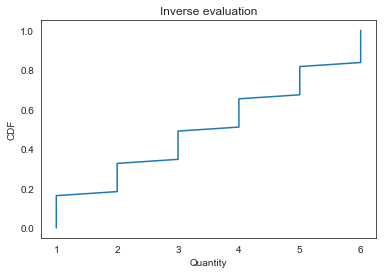

In [46]:
ps = np.linspace(0, 1)
qs = d6.quantile(ps)
plt.plot(qs, ps)
decorate_cdf('Inverse evaluation')

These functions provide a simple way to make a Q-Q plot.

Here are two samples from the same distribution.

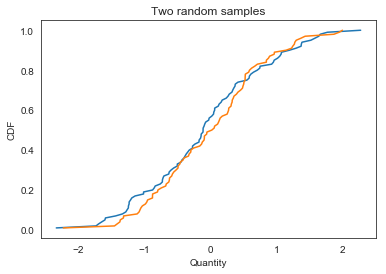

In [47]:
cdf1 = Cdf.from_seq(np.random.normal(size=100))
cdf2 = Cdf.from_seq(np.random.normal(size=100))

cdf1.plot()
cdf2.plot()
decorate_cdf('Two random samples')

Here's how we compute the Q-Q plot.

In [48]:
def qq_plot(cdf1, cdf2):
    """Compute results for a Q-Q plot.
    
    Evaluates the inverse Cdfs for all range of cumulative probabilities.

    
    :param cdf1: Cdf
    :param cdf2: Cdf
    
    :return: tuple of arrays
    """
    ps = np.linspace(0, 1)
    q1 = cdf1.quantile(ps)
    q2 = cdf2.quantile(ps)
    return q1, q2

The result is near the identity line, which suggests that the samples are from the same distribution.

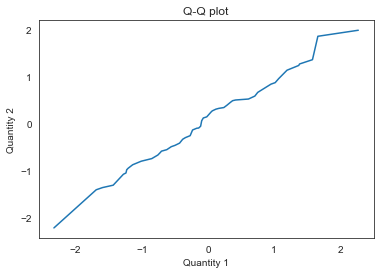

In [49]:
q1, q2 = qq_plot(cdf1, cdf2)
plt.plot(q1, q2)
plt.xlabel('Quantity 1')
plt.ylabel('Quantity 2')
plt.title('Q-Q plot');

Here's how we compute a P-P plot

In [50]:
def pp_plot(cdf1, cdf2):
    """Compute results for a P-P plot.
    
    Evaluates the Cdfs for all quantities in either Cdf.
    
    :param cdf1: Cdf
    :param cdf2: Cdf
    
    :return: tuple of arrays
    """
    qs = cdf1.index.union(cdf2)
    p1 = cdf1(qs)
    p2 = cdf2(qs)
    return p1, p2

And here's what it looks like.

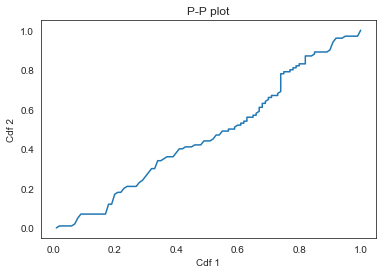

In [51]:
p1, p2 = pp_plot(cdf1, cdf2)
plt.plot(p1, p2)
plt.xlabel('Cdf 1')
plt.ylabel('Cdf 2')
plt.title('P-P plot');

### Statistics

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/7).

`Cdf` overrides the statistics methods to compute `mean`, `median`, etc.

In [52]:
psource(Cdf.mean)

    def mean(self):
        """Expected value.

        :return: float
        """
        return self.make_pmf().mean()



In [53]:
d6.mean()

3.5

In [54]:
psource(Cdf.var)

    def var(self):
        """Variance.

        :return: float
        """
        return self.make_pmf().var()



In [55]:
d6.var()

2.916666666666667

In [56]:
psource(Cdf.std)

    def std(self):
        """Standard deviation.

        :return: float
        """
        return self.make_pmf().std()



In [57]:
d6.std()

1.7078251276599332

### Sampling

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/8).

`choice` chooses a random values from the Cdf, following the API of `np.random.choice`

In [58]:
psource(Cdf.choice)

    def choice(self, *args, **kwargs):
        """Makes a random sample.

        Uses the probabilities as weights unless `p` is provided.

        args: same as np.random.choice
        options: same as np.random.choice

        :return: NumPy array
        """
        # TODO: Make this more efficient by implementing the inverse CDF method.
        pmf = self.make_pmf()
        return pmf.choice(*args, **kwargs)



In [59]:
d6.choice(size=10)

array([4, 6, 3, 5, 2, 3, 1, 3, 3, 1])

`sample` chooses a random values from the `Cdf`, following the API of `pd.Series.sample`

In [60]:
psource(Cdf.sample)

    def sample(self, *args, **kwargs):
        """Makes a random sample.

        Uses the probabilities as weights unless `weights` is provided.

        This function returns an array containing a sample of the quantities in this Pmf,
        which is different from Series.sample, which returns a Series with a sample of
        the rows in the original Series.

        args: same as Series.sample
        options: same as Series.sample

        :return: NumPy array
        """
        # TODO: Make this more efficient by implementing the inverse CDF method.
        pmf = self.make_pmf()
        return pmf.sample(*args, **kwargs)



In [61]:
d6.sample(n=10, replace=True)

array([2, 5, 5, 2, 6, 2, 3, 6, 4, 1])